<img align="right" src="images/DSApps_logo_small.jpg">

# DSApps 2021 @ TAU: Assignment 5

### Giora Simchoni

### Network Analysis with NetworkX

### Welcome

Welcome to Assignment 5 in Python!

Remember:

* You can play with the assignment in Playground mode, but:
* Only your private Github repository assigned to you by the course admin will be cloned and graded (Submission mode, see instructions [here](https://github.com/DSApps-2021/Class_Slides/blob/main/Apps_of_DS_HW.pdf))
* Like any other University assignment, your work should remain private
* You need to `git clone` your private Github repository locally as explained [here](https://github.com/DSApps-2021/Class_Slides/blob/main/Apps_of_DS_HW.pdf)
* You need to uncomment the starter code inside the chunk, replace the `### YOUR CODE HERE ###`, run the chunk and see that you're getting the expected result
* Pay attention to what you're asked to do and the required output
* For example, using a *different* function than the one you were specifically asked to use, will decrease your score (unless you amaze me)
* Your notebook should run smoothly from start to end if someone presses in the Jupyter toolbar Kernel --> Restart & Run All
* When you're done save the entire notebook into a html file, this is the file that would be graded
* You can add other files but do not delete any files
* Commit your work and push to your private Github repository as explained [here](https://github.com/DSApps-2021/Class_Slides/blob/main/Apps_of_DS_HW.pdf)

This assignemtnt is due: 9/5 23:59

### Libraries

These are the libraries you will need. If you don't have them, you need to uncomment the `!pip install` line and install them first (you can also just copy this command to a terminal and do it there if you don't want all the output printed in this notebook).

In [1]:
#!pip install matplotlib numpy scipy pandas networkx python-louvain

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from itertools import combinations # not mandatory

### The Films to Actors 2010s Dataset



For the first part of the assignment we are going to use the 2010 films actors network we scraped from Wikipedia.

For details regarding the network, how it was scraped and possible limitations - see [HW4](https://github.com/DSApps-2020/HW4).

Read in the data, it is pretty self explanatory:

In [3]:
films_actors_edgelist = pd.read_csv('data/films_actors_edgelist_2010s.csv', usecols=['film', 'actor', 'year'])

### Creating the Network

##### (0 points)

Here we are using `method 2` from HW4 to create the network `A`:

In [4]:
def print_network_info(G):
    print('no. of nodes: %d' % G.number_of_nodes())
    print('no. of edges: %d' % G.number_of_edges())
    print('no. of James Franco neighbors: %d' % len(list(G.neighbors('James Franco'))))

In [5]:
A_temp = nx.from_pandas_edgelist(films_actors_edgelist, 'film', 'actor', ['year'])
films = films_actors_edgelist['film'].unique()
actors = films_actors_edgelist['actor'].unique()

A = nx.bipartite.projected_graph(A_temp, actors)

print_network_info(A)

no. of nodes: 4743
no. of edges: 39319
no. of James Franco neighbors: 107


### Models

##### (40 points)

**ER Model**

Estimate $p$, the probability of an actor collaborating with another actor, according to the ER model:

In [6]:
edges_num, nodes_num = A.number_of_edges(), A.number_of_nodes()
p = edges_num / (nodes_num * (nodes_num-1) / 2)
print(f"p estimation of an actor collab with another actor {p:.4f}")

p estimation of an actor collab with another actor 0.0035


What is the esitmated transitivity of our network according to the ER model? What is the actual transitivity?

In [7]:
print(f"Estimated transitivity - {p:.4f}")
print(f"Actual transitivity - {nx.transitivity(A):.2f}")

Estimated transitivity - 0.0035
Actual transitivity - 0.25


What is the estimated diameter of our network according to the ER model? What is the actual diameter?

In [8]:
estimated_diameter = np.log(nodes_num) / np.log((nodes_num-1)*p)
print(f"Estimated diameter - {estimated_diameter:.4f}")
print(f"Actual transitivity - infinity as graph is not connected")

Estimated diameter - 3.0142
Actual transitivity - infinity as graph is not connected


According to the ER model, at what *stage* of connectedness our network is in? Is it in that stage?

In [9]:
mean_degree = (2*edges_num)/nodes_num
n_ln = np.log(nodes_num)

print(f"According to ER model we are at stage : fully connected\n\
as mean_degree = {mean_degree:.4f} > {n_ln:.4f} = ln(number of graph nodes)")

print(f"But it's not in that stage as the graph is not connected,\
 number of connected components are - {nx.number_connected_components(A)}")


According to ER model we are at stage : fully connected
as mean_degree = 16.5798 > 8.4644 = ln(number of graph nodes)
But it's not in that stage as the graph is not connected, number of connected components are - 122


**Power Law Model**

Estimate $\alpha$ and $d_{min}$, the Power Law parameters fitting the actors network. Use the `fit_pl()` function from class in spite of its limitations.

In [10]:
def fit_pl(G):
  degree_seq = np.array(list(dict(G.degree()).values()))
  n = G.number_of_nodes()
  # estimating d_min as min(d) is NOT right!
  d_min = np.min(degree_seq)
  if d_min == 0:
    d_min = 1
    degree_seq = degree_seq[degree_seq >= 1]
    n = len(degree_seq)
  alpha = 1 + n/np.sum(np.log(degree_seq/d_min))
  davg = np.mean(degree_seq)
  Ed = d_min * (alpha - 1)/(alpha - 2) if alpha > 2 else np.inf
  dvar = np.var(degree_seq)
  Ed2 = d_min**2 * (alpha - 1)/(alpha - 3) if alpha > 3 else np.inf
  Vd = Ed2 - (Ed)**2 if alpha > 3 else np.inf
  return d_min, alpha, davg, Ed, dvar, Vd

res = fit_pl(A)
print('Estimated alpha: %.2f' % res[1])
print('Estimated d_min: %.2f' % res[0])

Estimated alpha: 1.43
Estimated d_min: 1.00


What is the estimated mean and variance degree of our network according to the PL model?

In [11]:
print('Estimated mean degree: %.2f' % res[3])
print('Estimated variance degree: %.2f' % res[4])

Estimated mean degree: inf
Estimated variance degree: 372.95


Use the `degree_hist_with_pl_fit()` function from class to plot the fitted PL line on top of the degree histogram of our network (this function can be found at the start of the `u2_d05-models.Rmd` file). Do you "like" this fit?

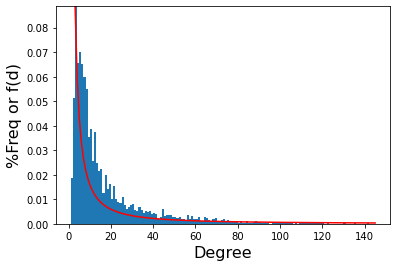

In [12]:
def degree_hist_with_pl_fit(G, alpha, dmin, xlabel='Degree', ylabel='%Freq or f(d)'):
  deg = [deg for node, deg in G.degree()]
  N, bins, patches = plt.hist(deg, density=True, bins=range(dmin, min(max(deg), 1000)))
  d = bins
  f_d = ((alpha-1)/dmin**alpha)*(d/dmin)**(-alpha)
  plt.plot(d, f_d, color='red')
  res = plt.ylim(0, np.max(N))
  plt.xlabel(xlabel, fontsize=16)
  plt.ylabel(ylabel, fontsize=16)

degree_hist_with_pl_fit(A,res[1],res[0])

Use the `degree_hist_with_pl_fit_log_log()` function from class to plot the fitted PL log-log line on top of the log-log degree histogram of our network (this function can be found at the start of the `u2_d05-models.Rmd` file). Do you "like" this fit?

<ipython-input-13-df6c7d7f2ecb>:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.arange(1, max_pow), np.log(N/len(deg)), 'bo')


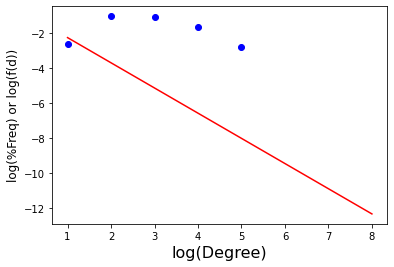

In [13]:
def degree_hist_with_pl_fit_log_log(G, alpha, dmin, xlabel='log(Degree)', ylabel='log(%Freq) or log(f(d))'):
  max_pow = 9
  deg = [deg for node, deg in G.degree() if deg > 0]
  N, bins = np.histogram(deg, bins = list(np.exp(np.arange(max_pow))))
  d = np.exp(np.arange(1, max_pow))
  f_d = ((alpha-1)/dmin)*(d/dmin)**(-alpha)
  plt.plot(np.arange(1, max_pow), np.log(N/len(deg)), 'bo')
  plt.plot(np.arange(1, max_pow), np.log(f_d), color='red')
  plt.xlabel(xlabel, fontsize=16)
  plt.ylabel(ylabel, fontsize=12)

degree_hist_with_pl_fit_log_log(A,res[1],res[0])

### Epidemics Models - the classic approach

##### (20 points)

* What is the minimum no. of people having a disease to put the entire population at risk?
* What is the minimum transfer rate of a disease needed to infect the entire population from a single sick person?
* What is the number of people who are expected to die of disease X with transfer rate p?

Such questions are the type of questions asked by epidemiologists, but not just. A disease could be a rumor or a piece of Fake News spreading through Whatsapp. A fashion trend on Instagram. Or even a power failure on an electrical grid.

In the classic approach to epidemics modeling there is no use of networks at all. In the *fully mixed* model it is assumed that we, the population, are some kind of particles moving in space, equally likely to meet any other person at any given time. This is of course not true in most cases.

#### The SI Model: S $\rightarrow$ I

In the most basic so-called *compartmental models* of epidemics, the population of $n$ people is divided in two: $S(t)$ which is the number of people *susceptible* to the disease at time $t$ (say day $t$), and $I(t)$ which is the number of people *infected* by the disease at time $t$. So at any given time: $S(t) + I(t) = n$

A person has a constant average no. of random contacts at any given time $\beta$, therefore the transfer rate of the disease is $\beta I(t)/n$ at time $t$.

It is not hard to derive the formula for $I(t)$ at any given time, dependent on $\beta$ and $I(0)$, which is the number of infected individuals at time $0$. But it does require some calculus out of the scope of this assignment. Let us use the power of Python instead!

But before we start: try to anticipate based on your intuition, what would be $I$ after enough $t$ time units have passed?

Run the following simulation for a small town of 10,000 people, 10 people are infected on day 0, and let's say the rate of random contacts distributes $Poisson(0.1)$ (on average 0.1 contact per day - very high level of social distancing).

In [14]:
n = 10000
I0 = 10
beta = 0.1
I = [I0]
population = np.zeros(n)
population[np.arange(I0)] = 1
t = 0
phi0 = I0/n
phi = [phi0]
Idiff = []
while True:
    for i in range(int(I[t])):
        beta_i = np.random.poisson(beta, size=1)[0]
        met = np.random.choice(n, size=beta_i, replace=False)
        population[met] = 1
        if np.sum(population) == n:
            break
    It = np.sum(population)
    I.append(It)
    Idiff.append(I[t + 1] - I[t])
    print('Day %d: %d infected, %.2f transfer rate' % (t, I[t], beta * It / n))
    phi.append(It/n)
    t += 1
    if np.isclose(It,n):
        print('Done.')
        break

Day 0: 10 infected, 0.00 transfer rate
Day 1: 11 infected, 0.00 transfer rate
Day 2: 12 infected, 0.00 transfer rate
Day 3: 12 infected, 0.00 transfer rate
Day 4: 14 infected, 0.00 transfer rate
Day 5: 18 infected, 0.00 transfer rate
Day 6: 19 infected, 0.00 transfer rate
Day 7: 19 infected, 0.00 transfer rate
Day 8: 21 infected, 0.00 transfer rate
Day 9: 23 infected, 0.00 transfer rate
Day 10: 26 infected, 0.00 transfer rate
Day 11: 28 infected, 0.00 transfer rate
Day 12: 29 infected, 0.00 transfer rate
Day 13: 33 infected, 0.00 transfer rate
Day 14: 36 infected, 0.00 transfer rate
Day 15: 37 infected, 0.00 transfer rate
Day 16: 41 infected, 0.00 transfer rate
Day 17: 46 infected, 0.00 transfer rate
Day 18: 50 infected, 0.00 transfer rate
Day 19: 52 infected, 0.00 transfer rate
Day 20: 57 infected, 0.00 transfer rate
Day 21: 62 infected, 0.00 transfer rate
Day 22: 73 infected, 0.00 transfer rate
Day 23: 81 infected, 0.00 transfer rate
Day 24: 90 infected, 0.00 transfer rate
Day 25: 98

So after...

In [15]:
t

185

...days, the entire town is infected (and much less if we look at say 90% of town).

Look at the $I(t)$ vs. $t$ graph. We'll also add in the theoretical $I(t)$ exponential growth curve which comes from solving a simple differential equation, out of this assignment scope:

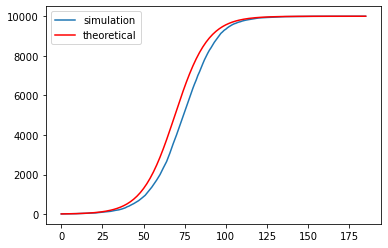

In [16]:
ts = np.arange(t + 1)
I_theoretical = (n * I0 * np.exp(beta * ts)) / (n - I0 + I0 * np.exp(beta * ts))

plt.plot(ts, I, label = 'simulation')
plt.plot(ts, I_theoretical, color = 'red', label = 'theoretical')
plt.legend()
plt.show()

Question: about 10% of infected individuals need ventilators (say "forever") and the local hospital has 10 of these at best. On what day will the local hospital run out of ventilators? [Not a tricky question, do not over analyze it]


In [17]:
## Answer
print(f"on day {np.argmax(np.array(I) >= 100)}")

on day 26


It's also interesting to see the derivative of this graph, which means the no. of *new* infected individuals each day:

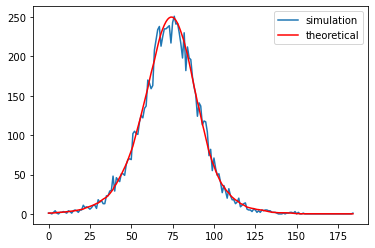

In [18]:
Idiff_theoretical = beta * np.array(I[:-1]) * (n - np.array(I[:-1]))/n

plt.plot(np.arange(t), Idiff, label = 'simulation')
plt.plot(np.arange(t), Idiff_theoretical, color='red', label = 'theoretical')
plt.legend()
plt.show()

Question: the local hospital daily intake capacity is 100 new patients at best. On what day will the local hospital maximize its intake capacity? [Not a tricky question, do not over analyze it]

In [19]:
## Answer
index = np.argmax(np.array(Idiff) >= 100)
print(f"on day {index+1} with {int(Idiff[index])} new patients")

on day 52 with 102 new patients


Write a function `SI(n, I0, beta)` which takes:
* `n` population size
* `I0` number of infected individuals at time `t`
* `beta`, the average rate of random contacts

and returns:
* `t` no. of days until entire town is infected
* `I` the list of daily total infected individuals
* `Idiff` the list of daily new infected individuals

[yes, you basically need to copy paste]

In [20]:
def SI(n, I0, beta):
    I = [I0]
    population = np.zeros(n)
    population[np.arange(I0)] = 1
    t = 0
    phi0 = I0/n
    phi = [phi0]
    Idiff = []
    while True:
        for i in range(int(I[t])):
            beta_i = np.random.poisson(beta, size=1)[0]
            met = np.random.choice(n, size=beta_i, replace=False)
            population[met] = 1
            if np.sum(population) == n:
                break
        It = np.sum(population)
        I.append(It)
        Idiff.append(I[t + 1] - I[t])
        phi.append(It/n)
        t += 1
        if np.isclose(It,n):
            break
    return t, I, Idiff

Run this function for our small town, keep `I0` at 1 infected individual, but change `beta` to be in `[0.1, 1, 2, 10]`.

Plot $I(t)$ vs. $t$ for the 4 simulations on the same graph:

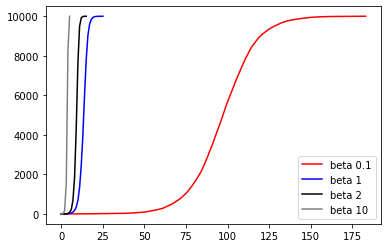

In [21]:
col = ['red','blue','black','grey']
for i, b in enumerate([0.1,1,2,10]):
    res = SI(10000,1,b)
    ts = np.arange(res[0] + 1)
    plt.plot(ts, res[1], color = col[i], label = f"beta {b}")
plt.legend()
plt.show()


As you might have guessed, in the SI model everyone will be infected eventually **at the same time**. The only question is when, and unless $\beta$, the no. of random contacts is extremely small (0.1 means meeting one person every 10 days!), this will happen lightning fast.

#### The SIR Model: S $\rightarrow$ I $\rightarrow$ R

There are many non-realistic assumptions under the SI model's hood, e.g.:
* no differentiation between being exposed, being infected and being ill
* same level of susceptibility, same level of infectiveness
* no treatment of immunization
* no treatment of birth and mortality
* assuming only one disease
* assuming constant contact rate

But perhaps the most striking one is that **there is no chance of recovery**.

The SIR model presents another compartment, $R(t)$ which is the number of people *recovered* at time $t$, so: $S(t) + I(t) + R(t)= n$. And note: recovered also means *immuned* (or dead...), these people **cannot** become infected again.

Additional recovery rate is needed, and it is $\gamma$, the average no. of recovered individuals at a time unit (say day), so if it distributes $Poisson(\gamma)$, then the time until recovery distributes exponentially with $1/\gamma$ days until recovery on average (again unrealistic).

Run the following simulation for our small town of 10,000 people. Now, 1 person is infected on day 0. The rate of random contacts $\beta$ distributes $Poisson(1)$ (on average 1 contact per day). In addition, let's say the rate of recovery $\gamma$ distributes $Poisson(0.1)$ (so time until recovery distributes $Exp(0.1)$, and average time until recovery is 10 days).

In [22]:
n = 10000
I0 = 1
beta = 1
gamma = 0.1
infected_times = np.repeat(None, n)
times_to_recovery = np.repeat(None, n)
infected_times[np.arange(I0)] = -1
times_to_recovery[np.arange(I0)] = 1/gamma
infected = np.arange(I0)
recovered = np.array([])
t = 0
I = [I0]
Idiff = []
R = [0]
S = [n - len(infected)]
while len(infected) > 0:
    for i in infected:
        beta_i = np.random.poisson(beta, size=1)[0]
        met = np.random.choice(n, size=beta_i, replace=False)
        met = met[(~np.isin(met, infected)) & (~np.isin(met, recovered))]
        if len(met) > 0:
            infected = np.append(infected, met)
            infected_times[met] = t
            times_to_recovery[met] = np.random.exponential(1/gamma, size=len(met))[0]
        if t - infected_times[i] > times_to_recovery[i]:
            infected = infected[infected != i]
            recovered = np.append(recovered, i)
        if len(recovered) == n:
            break
    I.append(len(infected))
    Idiff.append(I[t + 1] - I[t])
    R.append(len(recovered))
    S.append(n - (I[t] + R[t]))
    print('Day %d: %d infected, %d recovered' % (t, I[t], R[t]))
    t += 1
    if np.isclose(len(recovered), n, atol=3):
        break
print('Done.')
        
    

Day 0: 1 infected, 0 recovered
Day 1: 2 infected, 0 recovered
Day 2: 7 infected, 0 recovered
Day 3: 10 infected, 0 recovered
Day 4: 20 infected, 0 recovered
Day 5: 36 infected, 4 recovered
Day 6: 64 infected, 8 recovered
Day 7: 133 infected, 13 recovered
Day 8: 239 infected, 22 recovered
Day 9: 439 infected, 42 recovered
Day 10: 772 infected, 80 recovered
Day 11: 1380 infected, 148 recovered
Day 12: 2309 infected, 290 recovered
Day 13: 3595 infected, 509 recovered
Day 14: 5116 infected, 807 recovered
Day 15: 6369 infected, 1263 recovered
Day 16: 6895 infected, 1855 recovered
Day 17: 6868 infected, 2506 recovered
Day 18: 6585 infected, 3119 recovered
Day 19: 6112 infected, 3738 recovered
Day 20: 5633 infected, 4278 recovered
Day 21: 5152 infected, 4789 recovered
Day 22: 4682 infected, 5282 recovered
Day 23: 4276 infected, 5702 recovered
Day 24: 3878 infected, 6106 recovered
Day 25: 3493 infected, 6498 recovered
Day 26: 3150 infected, 6844 recovered
Day 27: 2873 infected, 7125 recovered


So after...

In [23]:
t

98

...days, the entire town is recovered after it had been infected (and much less if we look at say 90% of town).

Look at the $S(I),I(t),R(I)$ vs. $t$ graph.

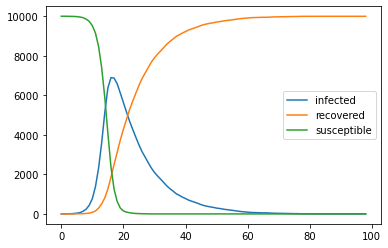

In [24]:
ts = np.arange(t + 1)

plt.plot(ts, I, label = 'infected')
plt.plot(ts, R, label = 'recovered')
plt.plot(ts, S, label = 'susceptible')
plt.legend()
plt.show()

It's also interesting to see the derivative of the $I(t)$ graph, which means the difference in infected individuals each day:

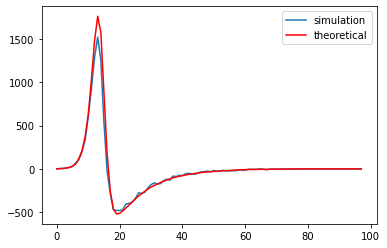

In [25]:
Idiff_theoretical = beta * np.array(I[:-1]) * (n - np.array(I[:-1]) - np.array(R[:-1]))/n - gamma * np.array(I[:-1])

plt.plot(np.arange(t), Idiff, label = 'simulation')
plt.plot(np.arange(t), Idiff_theoretical, color='red', label = 'theoretical')
plt.legend()
plt.show()

Notice that in the SIR model, **using these parameters**, the entire town population got infected as well.

But the SIR model gives some hope in containing the disease if it breaks, a.k.a "Flattening the Curve", which is achieved by lowering $\beta$, the average rate of random contacts.

Write a function `SIR(n, I0, beta, gamma)` which takes:
* `n` population size
* `I0` number of infected individuals at time `t`
* `beta`, the average rate of random contacts
* `gamma`, the average rate of recovered people

and returns:
* `t` no. of days until entire town is infected
* `I` the list of daily total infected individuals
* `Idiff` the list of daily difference in infected individuals
* `S` the list of daily total susceptible individuals
* `R` the list of daily total recovered individuals

[yes, you basically need to copy paste]

In [26]:
def SIR(n, I0, beta, gamma):
    infected_times = np.repeat(None, n)
    times_to_recovery = np.repeat(None, n)
    infected_times[np.arange(I0)] = -1
    times_to_recovery[np.arange(I0)] = 1/gamma
    infected = np.arange(I0)
    recovered = np.array([])
    t = 0
    I = [I0]
    Idiff = []
    R = [0]
    S = [n - len(infected)]
    while len(infected) > 0:
        for i in infected:
            beta_i = np.random.poisson(beta, size=1)[0]
            met = np.random.choice(n, size=beta_i, replace=False)
            met = met[(~np.isin(met, infected)) & (~np.isin(met, recovered))]
            if len(met) > 0:
                infected = np.append(infected, met)
                infected_times[met] = t
                times_to_recovery[met] = np.random.exponential(1/gamma, size=len(met))[0]
            if t - infected_times[i] > times_to_recovery[i]:
                infected = infected[infected != i]
                recovered = np.append(recovered, i)
            if len(recovered) == n:
                break
        I.append(len(infected))
        Idiff.append(I[t + 1] - I[t])
        R.append(len(recovered))
        S.append(n - (I[t] + R[t]))
        t += 1
        if np.isclose(len(recovered), n, atol=3):
            break
    return t, I, Idiff, S, R


Now run the simulation a few times with the same parameters, except $\beta$ is lowered to 0.5 (one contact every two days). Then plot the SIR curves as we did.

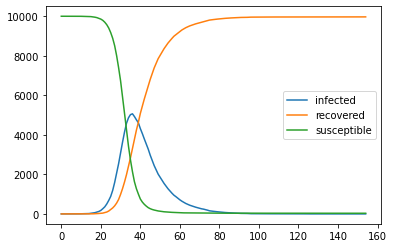

In [27]:
sir = SIR(10000, 1, 0.5, 0.1)

ts = np.arange(sir[0] + 1)
plt.plot(ts, sir[1], label = 'infected')
plt.plot(ts, sir[4], label = 'recovered')
plt.plot(ts, sir[3], label = 'susceptible')
plt.legend()
plt.show()

As you can see the $I(t)$ curve is indeed "flattened", though the entire town caught the disease eventually.

Must the disease outbreak? Must the entire population get infected?

Run the simulation with $\beta$ lowered to 0.1, and plot the SIR curves. Run it a few times to see how the outcome varies and consider not drawing the $S(I)$ curve to see the effect.

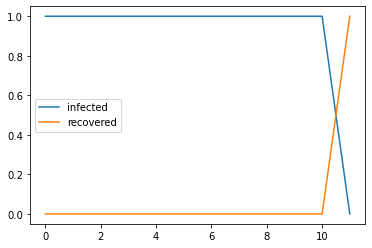

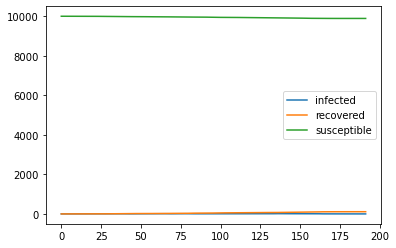

In [28]:
for i in range(2):
    sir = SIR(10000, 1, 0.1, 0.1)
    
    ts = np.arange(sir[0] + 1)
    plt.plot(ts, sir[1], label = 'infected')
    plt.plot(ts, sir[4], label = 'recovered')
    if i == 1:
        plt.plot(ts, sir[3], label = 'susceptible')
    plt.legend()
    plt.show()
    

As you can see by the SIR model, the epidemic might not outbreak at all if the rate of contacts is low enough and the rate of recovery is high enough. And if you play with the parameters you would see that even when the disease *does* take off, not all people in town might get it.

The $\beta/\gamma$ ratio is the critical point, irrelative of population size, and is sometimes called the Basic Reproduction Number. It can be seen as the number of people an infected person will infect until she recovers. If it is over 1 the epidemic will outbreak, and if it is less than 1 it should not. Read about it [here](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model_without_vital_dynamics) (short) or [here](https://web.stanford.edu/~jhj1/teachingdocs/Jones-on-R0.pdf) (long).

Lastly note that this is just the beginning. There are various other epidemics models (SIS, SEIR, SEIS, to drop-name a few). Read all about it.

### Epidemics Models - on Networks

##### (40 points)

Think about why an epidemic outbreak might be different when we consider the population has a network structure (as opposed to the fully mixed model above).

* A network might not be fully connected. So even in the pessimistic SI model an epidemic might not occur, depending on how well connected are the initial infected individuals.
* In general there would be variation in the level of spreading the disease. We expect the more connected a person is, the higher her rate of spreading the disease.
* If a network isn't dynamic, and each person stays connected to the same neighorhood - if that person is infected she will have depleted her potential of infecting other people on her neighborhood. She won't go on infecting forever.
* Finally even within networks we've seen different models for different structures. A network's structure could serve to impact the rate of infection, not just the nature of disease. How will an epidemic outbreak look like for a ER model network? How will it look like for a Power Law model network? What is the best network structure to slow down a disease?

#### SI Model on the Films Actors Network

First, when we speak of epidemic models on networks, many conventions remain the same, one main convention changes: the $\beta$ parameter. Here, the $\beta$ parameter will be the infection *probability* between an infected and a susceptible neighbors (as opposed to the general infection *rate* previously). Let's also assume it is a fixed probability, i.e. not a random variable as before.

And now I want you to start a SI epidemic on our films actors :) Kidding aside I want you to see the effect of degree a node has on the rate it will catch a disease.

Write a function `SI_network(G, beta, node_zero)` which will receive 3 parameters:
* `G` a NetworkX Graph()
* `beta` infection probability
* `node_zero` name of node (actor or actress) zero, who initially got infected

and return:
* `t` no. of days until the epidemic saturated, i.e. there was no change in no. of infected for 5 consecutive days (and you may assume `max(t) = 1000`
* `I` the list of daily total infected nodes (actors)
* `infected_time`: a <string: int> dictionary mapping a node (actor) to time `t` in which it got infected (if a node was not infected put `None`)

In [29]:
import random
def SI_network(G, beta, node_zero):
    d = {'nodes': list(G.nodes()), 'time': np.repeat(None, len(G.nodes()))}
    df = pd.DataFrame.from_dict(d)
    infected_nodes = {node_zero}
    df.loc[df['nodes'].str.contains(node_zero),'time'] = 0
    daily_infected_nodes = [1]
    t, consecutive_days, prev_infected = 0, 0, 1
    # Iterate until no change for 5 consecutive days or t reached 1000
    while consecutive_days < 4 and t < 1000:
        current_infected = np.array([])
        for node in infected_nodes:
            mask = np.random.binomial(n=1, p=1-beta, size=len(G[node]))
            neighbors = np.array(list(G[node]))
            newly_infected = np.ma.masked_array(neighbors,mask).compressed()
            current_infected = np.append(current_infected, newly_infected)
        t += 1
        df.loc[(df['time'].isnull()) & (df['nodes'].isin(current_infected)),'time'] = t
        infected_nodes.update(set(current_infected))
        # reset consecutive days if there is change in the number, otherwise increment by 1
        consecutive_days = consecutive_days + 1 if len(infected_nodes) == prev_infected else 0
        prev_infected = len(infected_nodes)
        daily_infected_nodes.append(len(infected_nodes))

    return t, daily_infected_nodes, dict(zip(df['nodes'],df['time']))


Run a SI simulation on the films actors network, with infection probability 0.1 and James Franco got infected.

In [30]:
result = SI_network(A, 0.1, "James Franco")

Plot the number of $I(t)$ vs $t$. Also include a horizontal line at $n$, number of actors.

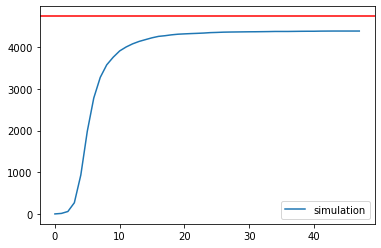

In [31]:
t = result[0]
daily_infected_nodes = result[1]
infected_time = result[2]

ts = np.arange(t + 1)
    
plt.plot(ts, daily_infected_nodes, label = 'simulation')
plt.axhline(y=len(A.nodes()), color='r', linestyle='-')
plt.legend()
plt.show()

As can be seen not all actors got infected. Show in code you understand why this is guaranteed for this simulation in this network:

In [32]:
if not nx.is_connected(A): 
    print("As we can see the network is not fully connected by using nx.is_connected(A) == False")

As we can see the network is not fully connected by using nx.is_connected(A) == False


Now use `infected_time` you got and plot the same graph of $I(t)$ vs. $t$ for nodes *with different degrees*, where $I(t, d)$ is normalized for all nodes with degree $d$.

* Ignore nodes with degree 0
* Nodes with degree 2^0 on a separate line
* Nodes with degree 2^0 < d <= 2^1 on a separate line
* Nodes with degree 2^1 < d <= 2^2 on a separate line
* Nodes with degree 2^2 < d <= 2^3 on a separate line
* ...        
* Nodes with degree 2^5 < d on a separate line

To help you it should look something like this (notice the y axis):

![](images/SI_actors_by_degree.png)

Also to help you (only if you need it, you don't have to use it), here's some starter code:

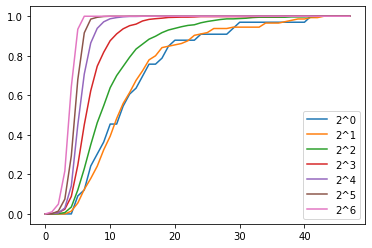

In [33]:
import math
actors_degrees = dict(A.degree)
degree_counter = {0: np.zeros(t + 1), 1: np.zeros(t + 1), 2: np.zeros(t + 1),
               3: np.zeros(t + 1), 4: np.zeros(t + 1), 5: np.zeros(t + 1),6: np.zeros(t+1)}
actors_dict = {actor: {'t': infected_time[actor], 'd': actors_degrees[actor]} for actor in A.nodes}
ts = np.arange(t+1)
for t_d in actors_dict.values():
    d = t_d['d']
    time = t_d['t']
    if time != None and d > 0:
        # get closest power of 2 check if the degree is power of 2
        position = int(math.log2(d))
        if d != 1 and 2**position < d:
            position += 1
        position = 6 if position > 5 else position
        degree_counter[position][time] += 1

for power, arr in degree_counter.items():
    arr = arr.astype(int)
    arr = np.cumsum(arr)
    arr = (arr-np.min(arr))/(np.max(arr)-np.min(arr))
    plt.plot(ts,arr,label=f"2^{power}")
plt.legend()
plt.show()

Isn't that beautiful? Yes we're in the SI model. And yes the probability of infection $\beta$ is constant. But considering this is a network, the rate of infection depends on the node's degree or centrality. This can also be shown in the SIR model.

It can also be shown how $I(t)$ relates to the eigen centrality of the actors. It would be simpler to use `infected_time` and show a scatterplot of the average infected time for different levels of eigen centrality, say for centrality [0.0-0.01], [0.01-0.02], etc.

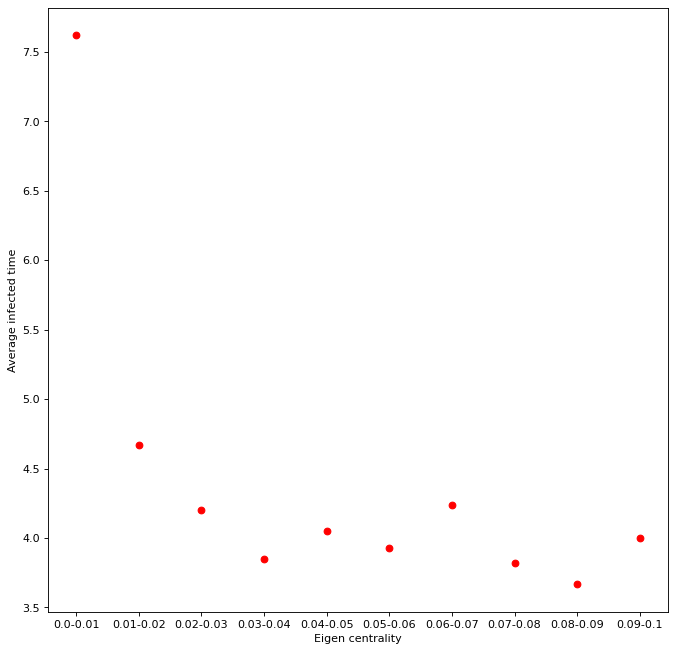

In [66]:
# took only bins in range 0.0 - 0.1 with 0.01 gaps as the maximum eigen centrality is ~0.097
from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=80)

centrality = nx.eigenvector_centrality(A)
max_cent = max(centrality.values())
max_bin = (int(max_cent*100))+1
bins = {(x/100):[0,0] for x in range(0,max_bin)}
infected_time = result[2]
for act,val in centrality.items():
    time = infected_time[act]
    if time != None:
        rounded = round(val,2) # 0.04151 -> 0.04
        if rounded - val > 0: # insert to the right bin as we round down
            rounded -= 0.01
        rounded = float("{:.2f}".format(rounded))
        bins[rounded][0] += time
        bins[rounded][1] += 1
y = np.zeros(max_bin)
x = []
for i,item in enumerate(bins.items()):
    val = item[1]
    key = item[0]
    key2 = round(key + 0.01,2)
    y[i] = val[0]/val[1]
    x.append(f"{key}-{key2}")

plt.scatter(x, y,color='red')
plt.ylabel("Average infected time")
plt.xlabel("Eigen centrality")
plt.show()

#### SIR Model on Power Law and Lattice networks

As mentioned in the beginning of this section, the structure of the network also dictates how the disease spreads. In the final part of the assignment we will show the difference of spreading a disease in a social-network-style Power Law network, vs. spreading it in a Lattice network.

For the SIR model, we also change the meaning of $\gamma$ and it is now the recovery *probability*, not rate, for a single infected node. So at each time unit, a node has a fixed probabilty of recovering (or dying...) from the disease, never to be infected again.

Write a function `SIR_network(G, beta, gamma, node_zero)` which will receive 4 parameters:
* `G` a NetworkX Graph()
* `beta` infection probability
* `gamma` recovery probability
* `node_zero` name of node zero, who initially got infected

and return:
* `t` no. of days until the epidemic saturated, i.e. there was no change in no. of recovered for 5 consecutive days (and you may assume `max(t) = 1000`
* `I` the list of daily total infected nodes
* `R` the list of daily total recovered nodes
* `S` the list of daily total susceptible nodes
* `infected_time`: a dictionary mapping an node to time `t` in which it got infected (if an node was not infected put `None`)

You may check that your function is working on the films actors network with James Franco as the infected actor, not required.

In [57]:
import random
def SIR_network(G, beta, gamma, node_zero):
    d = {'nodes': list(G.nodes()), 'time': np.repeat(None, len(G.nodes()))}
    df = pd.DataFrame.from_dict(d)
    df.loc[df['nodes'] == node_zero,'time'] = 0
    infected_nodes = {node_zero}
    recovered_nodes = np.array([])
    I, R, S = [1], [0],[len(G.nodes) - 1] 
    t, consecutive_days, prev_recovered = 0, 0, 0
    # Iterate until recovered people has no changed for 5 consecutive days or t reached 1000
    while consecutive_days < 4 and t < 1000:
        current_infected = np.array([])
        for node in infected_nodes:
            mask = np.random.binomial(n=1, p=1-beta, size=len(G[node]))
            neighbors = np.array(list(G[node]))
            newly_infected = np.ma.masked_array(neighbors, mask).compressed()
            current_infected = np.append(current_infected,newly_infected[np.isin(newly_infected,recovered)])
        
        t += 1
        # update the one's who didn't infected yet
        df.loc[(df['time'].isnull()) & (df['nodes'].isin(current_infected)),'time'] = t
        infected_nodes.update(set(current_infected))
        
        # recover nodes and update the infected nodes set
        mask = np.random.binomial(n=1, p=1-gamma, size=len(infected_nodes))
        new_recovered = np.ma.masked_array(np.array(list(infected_nodes)),mask).compressed()
        recovered_nodes = np.append(recovered_nodes,new_recovered)
        infected_nodes = infected_nodes.difference(set(recovered_nodes))

        I.append(len(infected_nodes))
        R.append(len(np.unique(recovered_nodes)))
        S.append(len(G.nodes) - (I[-1] + R[-1]))

        consecutive_days = consecutive_days + 1 if len(recovered_nodes) == prev_recovered else 0
        prev_recovered = len(recovered_nodes)

    return t, I, R, S, dict(zip(df['nodes'],df['time']))

Now create two networks:

* `G`: a Power-Law network with 900 nodes
* `L`: a Lattice (grid) network with 30x30 = 900 nodes (you'll get it when you see it...)

Run this code:

In [67]:
G = nx.powerlaw_cluster_graph(900, 3, 0.2)

L = nx.grid_2d_graph(30, 30)
mapping = {old: i for i, old in enumerate(L.nodes)}
L = nx.relabel_nodes(L, mapping)

Run the `SIR_network` simulation on `G` with `beta` 0.5 and `gamma` 0.1, make node 0 the first infected:

In [68]:
tG, IG, RG, SG, infected_time = SIR_network(G, 0.5, 0.1, 0)

Repeat with network `L`, same parameters:

In [69]:
tL, IL, RL, SL, infected_timeL = SIR_network(L, 0.5, 0.1, 0)

Now run the following code to be able to compare the spread of the disease in both networks:

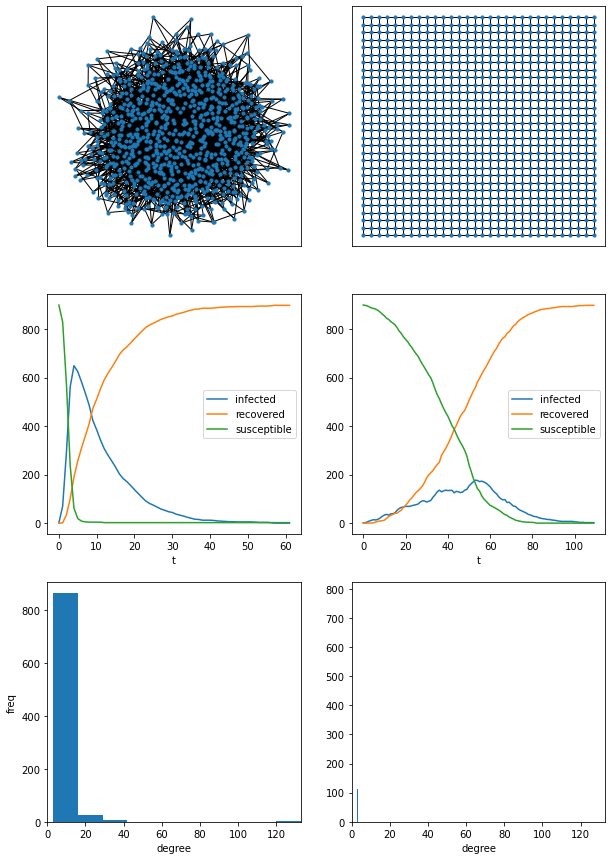

In [70]:
plt.rcParams['figure.figsize'] = [10, 15]
plt.subplot(3, 2, 1)
nx.draw_networkx(G, with_labels=False, node_size = 10)
plt.subplot(3, 2, 2)
pos = {i: old for old, i in mapping.items()}
nx.draw_networkx(L, pos = pos, with_labels=False, node_size = 10)
plt.subplot(3, 2, 3)
ts = np.arange(tG + 1)
plt.plot(ts, IG, label = 'infected')
plt.plot(ts, RG, label = 'recovered')
plt.plot(ts, SG, label = 'susceptible')
plt.legend()
plt.xlabel('t')
plt.subplot(3, 2, 4)
ts = np.arange(tL + 1)
plt.plot(ts, IL, label = 'infected')
plt.plot(ts, RL, label = 'recovered')
plt.plot(ts, SL, label = 'susceptible')
plt.legend()
plt.xlabel('t')
plt.subplot(3, 2, 5)
G_degrees =list(dict(G.degree).values())
plt.hist(G_degrees)
plt.xlim(0, max(G_degrees))
plt.xlabel('degree')
plt.ylabel('freq')
plt.subplot(3, 2, 6)
plt.hist(list(dict(L.degree).values()))
plt.xlim(0, max(G_degrees))
plt.xlabel('degree')
plt.show()

Explain in your own words:
* What is the difference between networks regarding the disease spread patterns?
* What might be the implications to the real world?
* You are the expert. The small-town social network you're researching is behaving Power-Law. Miss Honey, a local school teacher has just arrived from a vaction abroad and has been infected with a known virus for which a vaccine exists. Who would you recommend to vaccinate first and why?

Keep it short :)

###### 1. The difference between the networks :
###### Degree's - In the grid the maximal degree is 4, while in the power law it's much higher, and isn't guaranteed to be between 2-4.
###### 2. The implications are :
###### In the power law there will be massive peak in the infected people when a person with high degree will be infected, but in the grid it will be +- the same as the degrees are between 2-4.
###### 3. I would recommend to vaccianate first the people who are in contact with Miss Honey and they are familiar with a lot of other people(high degree), the reason is that they can infect many others quickly.
    

### Wrap up

And that's it, you've done some network modeling, you've seen what it can be used for and made some cool simulations which hopefully have improved your understanding of the spread of certain viruses and the dangerous world we're living in. Good luck with the rest of the course!